# TODO
- Save max acc epoch
- Read sep train set, validation set

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [25]:
print( f"TensorFlow {tf.__version__}" )
import sys
print( f"Python {sys.version}\n" )


TensorFlow 2.6.0
Python 3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]



In [26]:
model_input_h = 224  #input('image size :',)
train_batch_size = 50  #input('batch size :', )
if model_input_h == '':
    model_input_w = 224
    model_input_h = 224
else:
    model_input_h = int(model_input_h)
    model_input_w = model_input_h


if train_batch_size == '':
    train_batch_size = 100
else:
    train_batch_size = int(train_batch_size)
    
print(f'image size :{model_input_w}x{model_input_h}')
print('batch size :', train_batch_size)

image size :224x224
batch size : 50


# Read data

In [27]:
def read_infer_label(path, subset=None, size= (300,300), batch_size= 2, shuffle= False, validation_split=0.2):
    # directory = './resize/'
    # directory = './raw_data/'
    tf_raw_data = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode= 'int',#'categorical',
        # label_mode= 'int',#'categorical',
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=size,
        shuffle=shuffle, 
        seed=42,
        validation_split=validation_split,
        subset=subset,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )
    return tf_raw_data

In [28]:
# subet = 'validation'
# subset = 'training'

In [29]:
# raw_train = read_infer_label('./raw_data_train/', size= (model_input_w, model_input_h), batch_size= train_batch_size)
# raw_test = read_infer_label('./raw_data_test/', size= (model_input_w, model_input_h), batch_size= train_batch_size)

In [30]:
train_batch_size = 32

In [31]:
raw_train = read_infer_label('./raw_data_train/', subset='training', size= (model_input_w, model_input_h), batch_size= train_batch_size, shuffle= True)
raw_test = read_infer_label('./raw_data_train/', subset='validation', size= (model_input_w, model_input_h), batch_size= train_batch_size, shuffle= True)

Found 800 files belonging to 4 classes.
Using 640 files for training.
Found 800 files belonging to 4 classes.
Using 160 files for validation.


In [32]:
import os

# Set the directory containing your dataset
data_directory = './raw_data_train'

# Initialize an empty dictionary to store the counts for each class
class_counts = {}

# Iterate over the subdirectories in the main data directory
for class_name in os.listdir(data_directory):
    class_path = os.path.join(data_directory, class_name)
    if os.path.isdir(class_path):
        class_count = len(os.listdir(class_path))
        class_counts[class_name] = class_count

# Display the counts for each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")
    
print(raw_train.class_names)# == np.array([0.,1.,0.,0.])

Class: adventure, Count: 200
Class: cruiser, Count: 200
Class: dirt, Count: 200
Class: sport, Count: 200
['adventure', 'cruiser', 'dirt', 'sport']


# Pre processing

## Data Augmentation

In [33]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(model_input_w, model_input_h,3)),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                          tf.keras.layers.RandomRotation(factor=0.05, fill_mode='wrap', name='rand_rot'),
                                          tf.keras.layers.RandomZoom(height_factor=  (-0.3, -0.2), fill_mode= 'constant'),

                                      ],
                                     name='dataaug' )

dataaug.summary()

Model: "dataaug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rand_flip (RandomFlip)       (None, 224, 224, 3)       0         
_________________________________________________________________
rand_rot (RandomRotation)    (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Define a function to apply the sequential pipeline to the data
def apply_pipeline(image, label):
    return dataaug(image), label

# Apply the sequential pipeline to the dataset
augmented_data = raw_train.map(apply_pipeline)

# Iterate over the dataset and display the augmented images
# c = 0
# for images, labels in augmented_data:
#     for i in range(len(images)):
#         plt.imshow(images[i] / 255)  # Assuming the images are in the range [0, 255]
#         plt.title(f"Label: {labels[i]}")
#         plt.show()
#         # c+=1
#         continue
#         # if c > 10:
#         #     breako
#         # break
#     # end
#     break
    

3


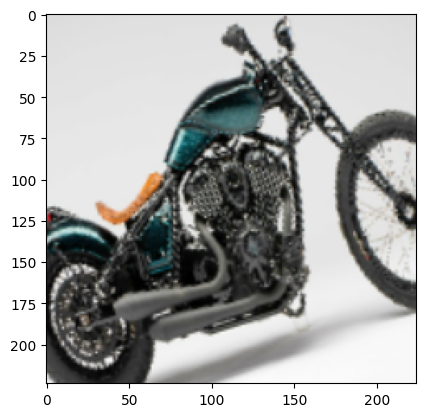

In [35]:
a = augmented_data.as_numpy_iterator()
plt.imshow(a.next()[0][0] / 255)
print(a.next()[1][0])

## Concat Raw and Augemented data

In [36]:
full_train = raw_train.concatenate(augmented_data)


## Scaling

In [37]:


scaling_layers = [
    # tf.keras.Input(shape= (model_input_w, model_input_h,3)),
    # tf.keras.layers.Rescaling(1./255)
    tf.keras.Input(shape= (224,224,3)),
    # tf.cast(dtype=tf.float32),
    # tf.keras.applications.resnet_v2.preprocess_input()
    tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input)
]

data_scaling = tf.keras.models.Sequential(
    scaling_layers,
    
    name= 'data_scaling'
)

data_scaling.summary()


Model: "data_scaling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [38]:
scaling_bool = True

def apply_scaling(image, label):
    return data_scaling(image), label

In [39]:

if scaling_bool == True:
    # Apply the sequential pipeline to the dataset
    full_train_prep = full_train.map(apply_scaling)
    raw_test = raw_test.map(apply_scaling)
    print('rescale')

else:
    full_train_prep = full_train
    print('normal scale')

        

rescale


## Data Details

In [40]:
batch = full_train_prep.as_numpy_iterator().next()
print('total data :', len(batch[0]) * len(full_train_prep))
print('N batch :', len(full_train_prep))
print('data shape :',batch[0][0].shape)
print('label example : ',batch[1][0])

total data : 1280
N batch : 40
data shape : (224, 224, 3)
label example :  0


# Transfer learning

## Get pre-trained model

### Exclude TOP

In [41]:
resnet_model = tf.keras.applications.ResNet50V2(
    include_top=False, # true จะใส่เขียวมา (ใส่ dense layer มาให้)
    # false จะไม่เอา dense สีเขียวมา
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
)

In [42]:
resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

# Pre test

In [20]:
label_lst = raw_train.class_names
# Function to display a sample of images along with their predicted labels
def plot_sample_images(images, labels, predictions=None):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)# / 255.0)
        # plt.imshow(image / 255.0)
        if predictions is not None:
            predicted_label = np.argmax(predictions[i])
            # print(predicted_label)
            true_label = label#np.argmax(label)
            plt.xlabel(f"Predicted: {label_lst[predicted_label]} (True: {label_lst[true_label]})", fontsize=6)
        # else:
        #     true_label = label #np.argmax(label)
        #     plt.xlabel(f"True: {true_label}")
        # print('true :', label, 'pred :', predicted_label, 'predict :', predictions[i])
    plt.show()

In [21]:
# def apply_scaling(image, label):
#     return data_scaling(image), label
# i = tf.keras.layers.Input([224,224,3], dtype = tf.uint8)
# x = tf.cast(i, tf.float32)
# new_input = tf.keras.applications.resnet_v2.preprocess_input(x)


In [43]:

resnet_model2 = resnet_model

# Input layer
_inputs = tf.keras.Input(shape= (224,224,3))
#############
_x = tf.cast(_inputs, tf.float32)
_x = tf.keras.applications.resnet_v2.preprocess_input(_x)
_x = resnet_model2(_x, training= False)
##########
# Combine input in base model
# _x = resnet_model2(_inputs, training= False)

# new layers
_x = tf.keras.layers.Flatten()(_x)
_outputs = tf.keras.layers.Dense(4, activation= 'softmax')(_x)

_base_model_pretest = tf.keras.Model(_inputs, _outputs)
# _base_model_pretest.summary()

In [44]:
_base_model_pretest.compile(optimizer= 'adam',
                     loss= 'sparse_categorical_crossentropy',
                     metrics= ['accuracy'])
pretest_ret = _base_model_pretest.evaluate(raw_test)
print(f'Pretest Score \nLoss :{pretest_ret[0]:.6f}  Accuracy :{pretest_ret[1]:.6f}')

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_1/resnet50v2/conv1_conv/Conv2D (defined at C:\Users\kimte\AppData\Local\Temp\ipykernel_23472\43314009.py:4) ]] [Op:__inference_test_function_14511]

Function call stack:
test_function


In [ ]:
label_lst = raw_train.class_names

# Convert the test data to numpy arrays
unbatched = np.array([[data[0].numpy(), data[1].numpy()] for data in raw_test.unbatch()])
test_images = np.array([data[0] for data in unbatched])
test_labels = np.array([data[1] for data in unbatched])

# Generate predictions on the test images
pretest_pred = _base_model_pretest.predict(raw_test)



C:\Users\kimte\AppData\Local\Temp\ipykernel_13772\3093533091.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unbatched = np.array([[data[0].numpy(), data[1].numpy()] for data in raw_test.unbatch()])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

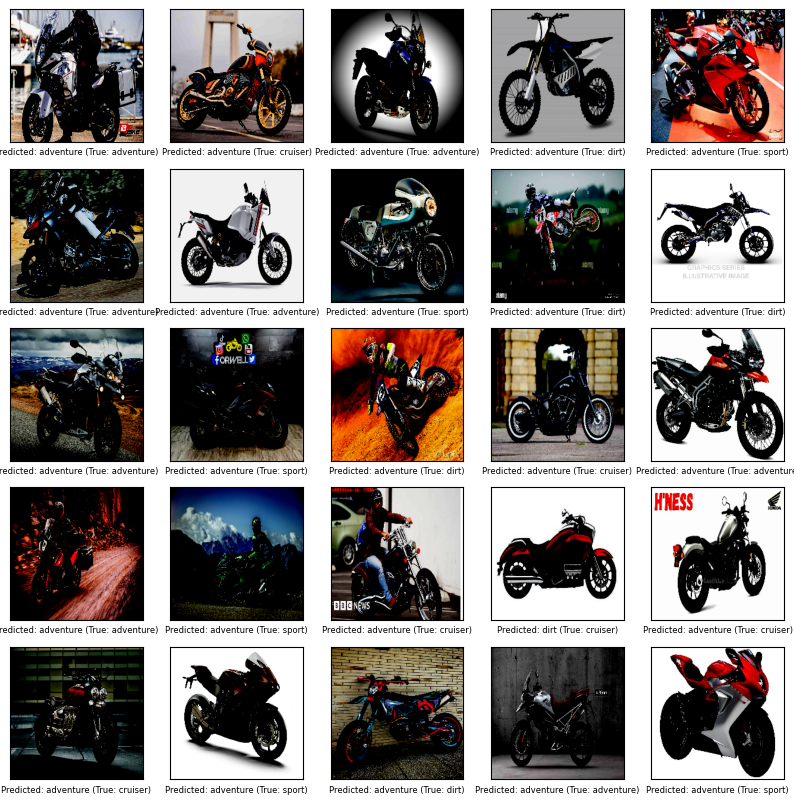

In [ ]:
plot_sample_images(test_images[:25], test_labels[:25], pretest_pred[:25])

### Prediction Score

In [ ]:
count_true = 0
for i in range(len(test_images)):
    if np.argmax(pretest_pred[i]) == test_labels[i]:
        count_true += 1
print('predict = true label ', 100*  count_true/ len(test_images) , '%')
    

predict = true label  26.25 %


In [ ]:
# def pred_one_img(model, img):
#     img = np.expand_dims(img, axis=0)
#     ret = model.predict(img)
#     return ret[0]

# # pred_one_img(resnet_model2, i)
# for i in raw_test.unbatch().as_numpy_iterator():
#     print(pred_one_img(resnet_model2, i[0]))

In [ ]:
# resnet_model2.compile(optimizer= 'adam',
#                      loss= 'sparse_categorical_crossentropy',
#                      metrics= ['accuracy'])
# pretest_ret = resnet_model2.evaluate(raw_test)

In [ ]:
# print(f'Pretest Score \nLoss :{pretest_ret[0]}  Accuracy :{pretest_ret[1]}')

### Freeze layers

### train only BN

In [ ]:
resnet_fz =resnet_model

for layer in resnet_fz.layers:
    if '_bn' in layer.name:
        # unfreeze
        layer.trainable = True
    else:
        # freeze 
        layer.trainable = False

### freeza all layer

In [ ]:
# resnet_fz =resnet_model

# for layer in resnet_fz.layers:
#     layer.trainable = False

### batch norm
- https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/

### TODO read
- https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8




In [ ]:
# -  The base model contains batchnorm layers. We want to keep them in inference mode
# -  when we unfreeze the base model for fine-tuning, so we make sure that the
# -  base_model is running in inference mode here.
# x = base_model(x, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# 
# outputs = keras.layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

#### แบบเดิม ที่มัน nested

In [ ]:

# # Input layer
# inputs = tf.keras.Input(shape= (224,224,3))

# # Combine input in base model
# x = resnet_fz(inputs, training= False)

# # new layers
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(0.4)(x) 
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(1024, activation= 'relu')(x)
# x = tf.keras.layers.Dropout(0.4)(x)  # Regularize with dropout
# x = tf.keras.layers.Dense(512, activation= 'relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x) 
# x = tf.keras.layers.Dense(64, activation= 'relu')(x)
# outputs = tf.keras.layers.Dense(4, activation= 'softmax')(x)

# transfer_model = tf.keras.Model(inputs, outputs)
# transfer_model.summary()


#### แบบใหม่ที่ ไม่ nested

In [ ]:


base_model_output = resnet_fz.output

x = tf.keras.layers.Flatten()(base_model_output)
x = tf.keras.layers.Dropout(0.4)(x) 
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation= 'relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)  # Regularize with dropout
x = tf.keras.layers.Dense(512, activation= 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) 
x = tf.keras.layers.Dense(64, activation= 'relu')(x)
outputs = tf.keras.layers.Dense(4, activation= 'softmax')(x)

transfer_model = tf.keras.Model(inputs= resnet_fz.inputs, outputs= outputs)
transfer_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# transfer_model.get_layer('resnet50v2').get_layer('conv1_pad')#.summary()

## Train with callback method

In [ ]:
from tensorflow.keras.callbacks import Callback

class MaxAccuracyEpochScoreSaver(Callback):
    def __init__(self):
        super(MaxAccuracyEpochScoreSaver, self).__init__()
        self.max_val_accuracy = 0.0
        self.max_val_epoch = 0
        self.scores = {}

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs['val_accuracy']
        if current_val_accuracy > self.max_val_accuracy:
            self.max_val_accuracy = current_val_accuracy
            self.max_val_epoch = epoch + 1
            self.scores = {
                'Epoch': self.max_val_epoch,
                'Training Loss': logs['loss'],
                'Training Accuracy': logs['accuracy'],
                'Validation Loss': logs['val_loss'],
                'Validation Accuracy': logs['val_accuracy']
            }

    def on_train_end(self, logs=None):
        print("Max Accuracy Epoch Scores:")
        for key, value in self.scores.items():
            print(f"{key}: {value}")




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

# Xception_callback/model_epoch{epoch:02d}_valloss{val_loss:.2f}.h5

# Defining Callbacks

checkpoint_filepath = "./callback/model_epoch.h5"
early_stop_patience = 60
reduce_lr_patience = 20
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = early_stop_patience,
                              verbose = 1)

checkpoint    = ModelCheckpoint(checkpoint_filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True,
                                save_weights_only=False, 
                                verbose = 1,
                                # option = tf.saved_model.SaveOptions
                                )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=reduce_lr_patience, min_lr=0.00005,verbose=1)

# Create an instance of the callback
max_accuracy_saver = MaxAccuracyEpochScoreSaver()

callback_list = [earlystopping, checkpoint,reduce_lr, max_accuracy_saver]

In [ ]:
# lr = 0.005
# _optimizer = tf.keras.optimizers.Adam( ema_momentum= 0.90)     
# transfer_model.compile(optimizer= _optimizer, #'adam',
#                      loss= 'categorical_crossentropy',
#                      metrics= ['accuracy'])

transfer_model.compile(optimizer= 'adam',
                     loss= 'sparse_categorical_crossentropy',
                     metrics= ['accuracy'])

# transfer_model.compile(optimizer= 'adam', #'adam
#                      loss= 'categorical_crossentropy',
#                      metrics= ['accuracy'])

In [ ]:


# # Add the callback to the list of callbacks when fitting the model
# # transfer_model.fit(full_train_prep, epochs=2, validation_data=raw_test, callbacks=[max_accuracy_saver])
# transfer_model.fit(full_train, 
#                    epochs=10, 
#                    validation_data=raw_test, 
#                    callbacks= callback_list)# [max_accuracy_saver])

In [ ]:


# Add the callback to the list of callbacks when fitting the model
# transfer_model.fit(full_train_prep, epochs=2, validation_data=raw_test, callbacks=[max_accuracy_saver])
transfer_model.fit(full_train_prep, epochs=30, 
                   validation_data=raw_test, 
                   callbacks= callback_list)#[max_accuracy_saver])

Epoch 1/200


40/40 [==============================] - 28s 461ms/step - loss: 0.9900 - accuracy: 0.6070 - val_loss: 0.6420 - val_accuracy: 0.7563

Epoch 00001: val_loss improved from inf to 0.64197, saving model to ./callback\model_epoch.h5


c:\Users\kimte\.conda\envs\tf-gpu2\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/200
40/40 [==============================] - 19s 436ms/step - loss: 0.5565 - accuracy: 0.7977 - val_loss: 0.7189 - val_accuracy: 0.7750

Epoch 00002: val_loss did not improve from 0.64197
Epoch 3/200
40/40 [==============================] - 18s 404ms/step - loss: 0.4049 - accuracy: 0.8383 - val_loss: 0.6839 - val_accuracy: 0.7812

Epoch 00003: val_loss did not improve from 0.64197
Epoch 4/200
40/40 [==============================] - 18s 407ms/step - loss: 0.3353 - accuracy: 0.8797 - val_loss: 0.3666 - val_accuracy: 0.8813

Epoch 00004: val_loss improved from 0.64197 to 0.36663, saving model to ./callback\model_epoch.h5
Epoch 5/200
40/40 [==============================] - 18s 419ms/step - loss: 0.2550 - accuracy: 0.9117 - val_loss: 0.4073 - val_accuracy: 0.8625

Epoch 00005: val_loss did not improve from 0.36663
Epoch 6/200
40/40 [==============================] - 18s 408ms/step - loss: 0.2473 - accuracy: 0.9180 - val_loss: 0.3073 - val_accuracy: 0.9187

Epoch 00006: val_loss im

# Evaluate

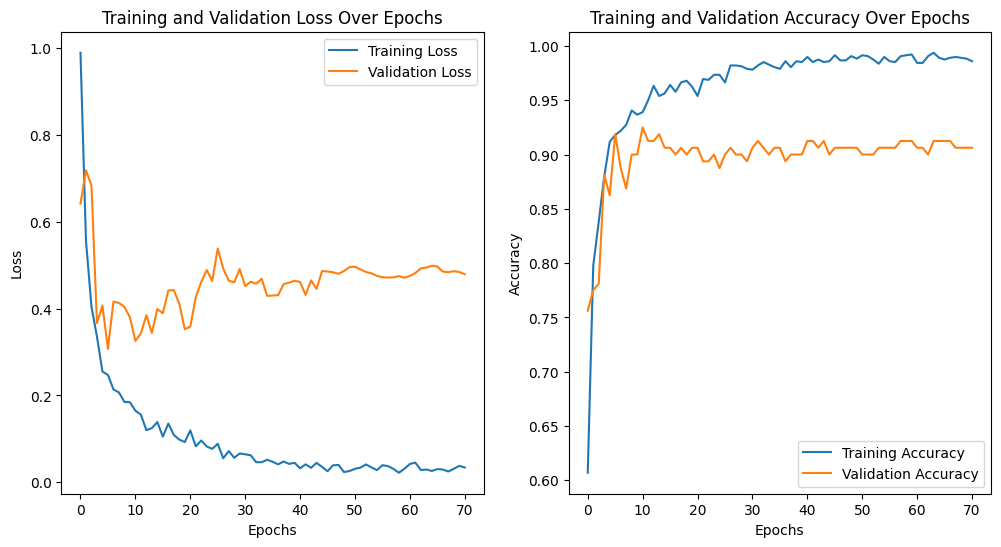

In [ ]:


# Assuming 'transfer_model' is the trained model
history = transfer_model.history.history

# Retrieve the training and validation loss and accuracy
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

# Create a plot for training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Create a plot for training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display the plots
plt.show()


In [ ]:
# TODO
# หลักจากได้ model แล้ว
# เอามา learn 3 รอบ โดยให้แต่ระรอบเซฟ learning rate ลง csv
# 3รอบ batch size ลง csv

## Load weights from best epoch

In [ ]:
from keras.models import load_model
model = load_model(checkpoint_filepath)

## TEST DATA

In [ ]:
scaling_bool = True
test_data = read_infer_label('./raw_data_test/', size= (model_input_w, model_input_h), batch_size= train_batch_size,shuffle= False,validation_split=None)
if scaling_bool == True:
    print('rescale')
    test_data = test_data.map(apply_scaling)

Found 200 files belonging to 4 classes.
rescale


## Evaluate test data

In [ ]:

loss, acc = model.evaluate(test_data)

print(f'before train  loss :{pretest_ret[0]:.6f}  acc :{pretest_ret[1]:.6f}',)
print(f'after train loss :{loss:.6f}   acc :{acc:.6f}', )





7/7 [==============================] - 3s 328ms/step - loss: 0.2707 - accuracy: 0.9250
before train  loss :1.751437  acc :0.256250
after train loss :0.270708   acc :0.925000


## PREDICT

### Convert test data to array

In [ ]:
label_lst = raw_train.class_names

# Convert the test data to numpy arrays
unbatched = np.array([[data[0].numpy(), data[1].numpy()] for data in test_data.unbatch()])
test_images = np.array([data[0] for data in unbatched])
test_labels = np.array([data[1] for data in unbatched])

# Generate predictions on the test images
predictions = model.predict(test_data)


C:\Users\kimte\AppData\Local\Temp\ipykernel_13772\2343804000.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unbatched = np.array([[data[0].numpy(), data[1].numpy()] for data in test_data.unbatch()])


### Brute force shuffle data

In [ ]:
len(test_images)
lst = []

test_images2 = []
test_labels2 = []
predictions2 = []
import random

lst = random.sample(range(0,len(test_images)), len(test_images))
for i in lst:
    test_images2.append(test_images[i])
    test_labels2.append(test_labels[i])
    predictions2.append(predictions[i])
    
test_images = test_images2
test_labels = test_labels2
predictions = predictions2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


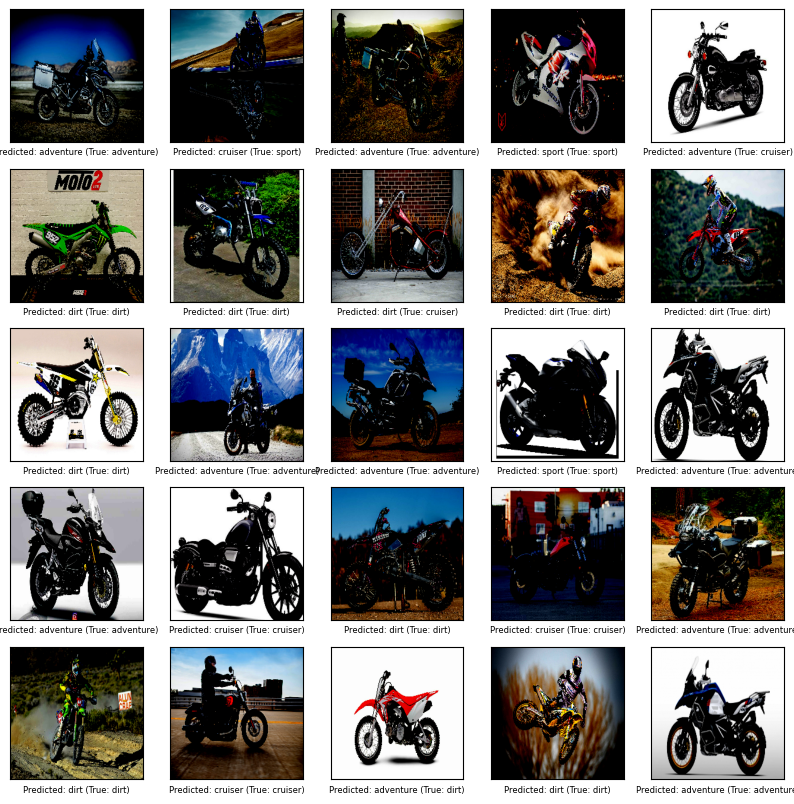

In [ ]:
# Plot a sample of the test images with their true and predicted labels
plot_sample_images(test_images[:25], test_labels[:25], predictions[:25])

## Grad-CAM

### new grad cam

In [ ]:

import matplotlib.cm as cm
from IPython.display import Image, display

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name= None, pred_index=None, last_layer_tf_type= None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    if last_layer_tf_type != None:
        grad_model = tf.keras.models.Model(
            model.inputs, [last_layer_tf_type.output, model.output]
        )
    else:
        
        grad_model = tf.keras.models.Model(
            model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
        )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam2(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    # img = tf.keras.utils.load_img(img_path)
    # img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # print('eiei')
    display(Image(cam_path))


# save_and_display_gradcam(img_path, heatmap)#, cam_path= )

Predict :adventure   Actual :adventure


C:\Users\kimte\AppData\Local\Temp\ipykernel_13772\410172603.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


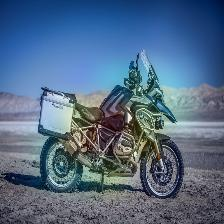

Predict :cruiser   Actual :sport


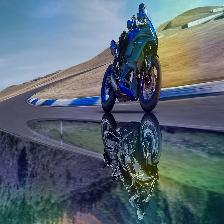

Predict :adventure   Actual :adventure


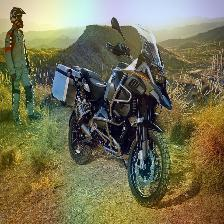

Predict :sport   Actual :sport


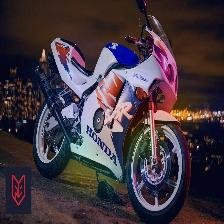

Predict :adventure   Actual :cruiser
Predict :dirt   Actual :dirt
Predict :dirt   Actual :dirt
Predict :dirt   Actual :cruiser
Predict :dirt   Actual :dirt
Predict :dirt   Actual :dirt


In [ ]:
last_conv_layer_name = 'conv5_block3_out'
for i in range(10):
    try:
        img_test = test_images[i]#.shape
        img_label = test_labels[i]
        img_pred = predictions[i]
        
        print(f'Predict :{label_lst[np.argmax(img_pred)]}   Actual :{label_lst[img_label]}')
        img_test_expand = np.expand_dims(img_test, axis=0)
        heatmap = make_gradcam_heatmap(img_test_expand, model, last_conv_layer_name, pred_index= i)
        save_and_display_gradcam2(img_test * 255, heatmap)
    except:
        pass
        

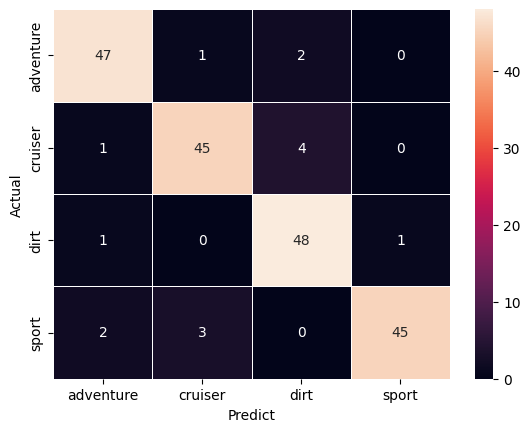

Precision = 0.925
Recall = 0.925
F1 Score = 0.925


In [ ]:

import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score


def plot_cunfusion_metrix(images, labels, predictions=None):
    global label_lst
    y_pred = []
    y_test = []
    for i, (image, label) in enumerate(zip(images, labels)):
        y_label = label_lst[int(label)]
        y_test.append(y_label)
        pred = label_lst[int(np.argmax(predictions[i]))]
        y_pred.append(pred)
    cm = confusion_matrix(y_test, y_pred,)
    ax = sns.heatmap(cm, annot = True, xticklabels = label_lst, yticklabels = label_lst, linewidth=.5, )
    ax.set(xlabel='Predict',ylabel='Actual')
    plt.show()
    precision = precision_score(y_test, y_pred,average= 'micro')
    recall = recall_score(y_test, y_pred,average= 'micro')
    f1score = f1_score(y_test, y_pred,average= 'micro')
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 Score = {f1score}")

# Plot a sample of the test images with their true and predicted labels
plot_cunfusion_metrix(test_images, test_labels, predictions)

# TRAIN 3-10 TIMES

In [ ]:
# CALL BACK TO CALCULATE MEAN , VAR
from tensorflow.keras.callbacks import Callback
from statistics import mean, variance

class MaxAccuracyEpochScoreSaver(Callback):
    def __init__(self):
        super(MaxAccuracyEpochScoreSaver, self).__init__()
        self.max_val_accuracy = 0.0
        self.max_val_epoch = 0
        self.scores = {}
        
        self.loss = []
        self.acc = []
        self.val_loss = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs['val_accuracy']
        if current_val_accuracy > self.max_val_accuracy:
            self.max_val_accuracy = current_val_accuracy
            self.max_val_epoch = epoch + 1
            self.scores = {
                'Epoch': self.max_val_epoch,
                'Training Loss': logs['loss'],
                'Training Accuracy': logs['accuracy'],
                'Validation Loss': logs['val_loss'],
                'Validation Accuracy': logs['val_accuracy']
            }
            
        self.loss.append(logs['loss'])
        self.acc.append(logs['accuracy'])
        self.val_loss.append(logs['val_loss'])
        self.val_acc.append(logs['val_accuracy'])

    def on_train_end(self, logs=None):
        # print("Max Accuracy Epoch Scores:")
        # for key, value in self.scores.items():
        #     print(f"{key}: {value}")
        
        ## Mean
        print('Mean loss:', mean(self.loss))
        print('Mean validation loss:', mean(self.val_loss))
        
        print('Mean acc:', mean(self.acc))
        print('Mean validation acc:', mean(self.val_acc))
        
        ## Varience
        print('Varience loss:', variance(self.loss))
        print('Varience validation loss:', variance(self.val_loss))
        
        print('Varience acc:', variance(self.acc))
        print('Varience validation acc:', variance(self.val_acc))
            
        




In [ ]:
# for loop to train, 
# 

# DEV

C:\Users\kimte\AppData\Local\Temp\ipykernel_13772\410172603.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


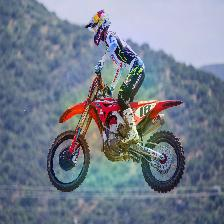

In [ ]:
last_conv_layer_name = 'conv5_block3_out'
img_test_expand = np.expand_dims(img_test, axis=0)
heatmap = make_gradcam_heatmap(img_test_expand, resnet_fz, last_conv_layer_name)
save_and_display_gradcam2(img_test * 255, heatmap)


C:\Users\kimte\AppData\Local\Temp\ipykernel_13772\410172603.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


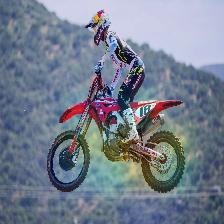

In [ ]:
last_conv_layer_name = 'conv5_block3_out'
img_test_expand = np.expand_dims(img_test, axis=0)
heatmap = make_gradcam_heatmap(img_test_expand, model, last_conv_layer_name)
save_and_display_gradcam2(img_test * 255, heatmap)


In [ ]:
for img_ in 

img_path_lst = [
    "./raw_data_test/adventure/timthumb.png",
    './raw_data_test/cruiser/tacita_urban_cruiser_blog.jpg',
    "./raw_data_test/dirt/MT-DB-X5-250cc_Black.jpg",
    './raw_data_test/sport/images535.jpg',
    
]

last_conv_layer_name = 'conv5_block3_out'
for img_path in img_path_lst:
    img_array = get_img_array(img_path, (224,224))
    heatmap = make_gradcam_heatmap(img_array, resnet_fz, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap)

### grad from path

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# last_conv_layer_name = 'conv5_block3_out'
# img_path = './raw_data_test/adventure/TRK_STYLE.jpg'
# img_path = './raw_data_test/cruiser/rocket-front.jpg'
# img_array = get_img_array(img_path, (224,224))
# heatmap = make_gradcam_heatmap(img_array, resnet_fz, last_conv_layer_name, pred_index=None)
plt.imshow(heatmap)

NameError: name 'heatmap' is not defined

In [ ]:
import matplotlib.cm as cm
from IPython.display import Image, display
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


# save_and_display_gradcam(img_path, heatmap)#, cam_path= )

In [ ]:
last_conv_layer_name = 'conv5_block3_out'
for i in raw_test.unbatch().as_numpy_iterator():
    # print(pred_one_img(transfer_model, i[0]))
    img_array = i[0]
    # break
    # print(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    heatmap = make_gradcam_heatmap(img_array, resnet_fz, last_conv_layer_name)
    save_and_display_gradcam(img_array, heatmap)
    break
    

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 70812: invalid continuation byte

In [ ]:
for img_ in 

img_path_lst = [
    "./raw_data_test/adventure/timthumb.png",
    './raw_data_test/cruiser/tacita_urban_cruiser_blog.jpg',
    "./raw_data_test/dirt/MT-DB-X5-250cc_Black.jpg",
    './raw_data_test/sport/images535.jpg',
    
]

last_conv_layer_name = 'conv5_block3_out'
for img_path in img_path_lst:
    img_array = get_img_array(img_path, (224,224))
    heatmap = make_gradcam_heatmap(img_array, resnet_fz, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap)


C:\Users\kimte\AppData\Local\Temp\ipykernel_20816\4131525126.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


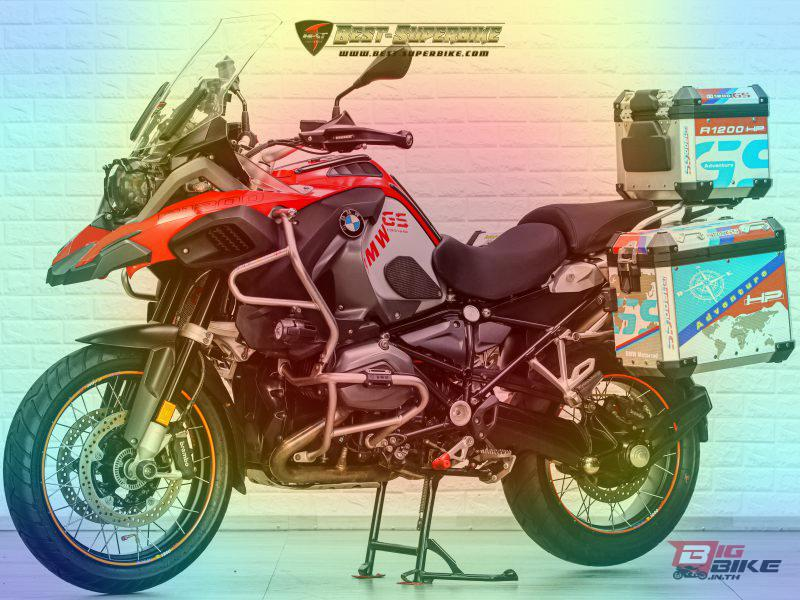

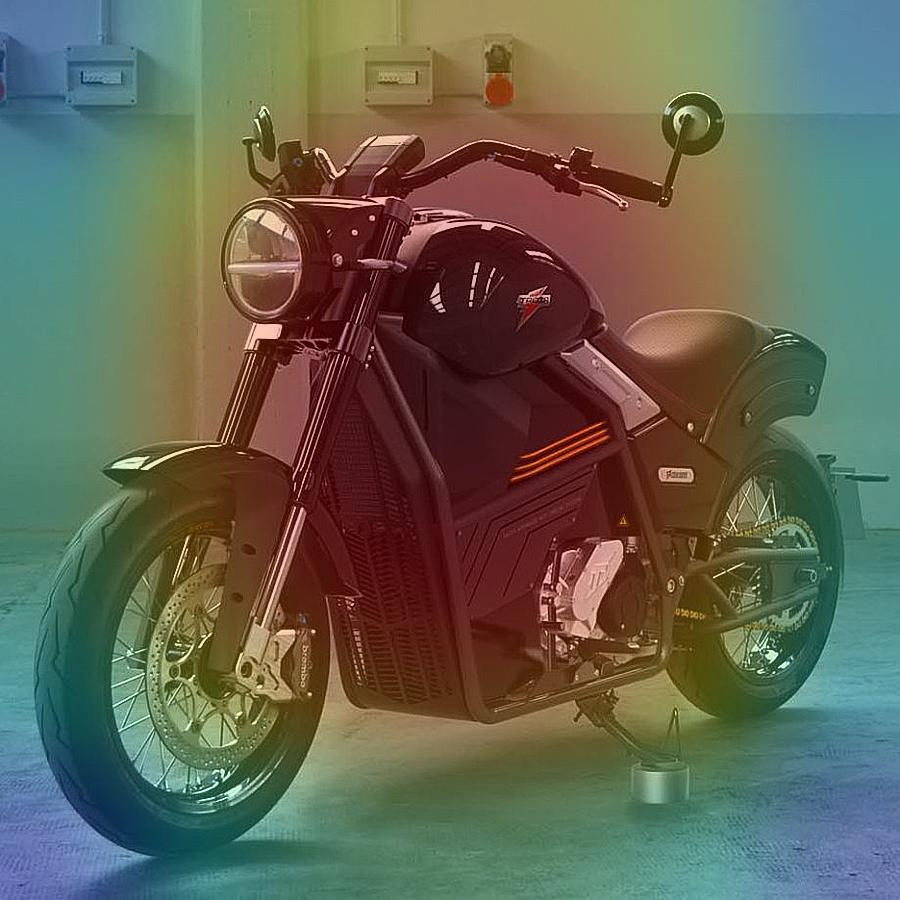

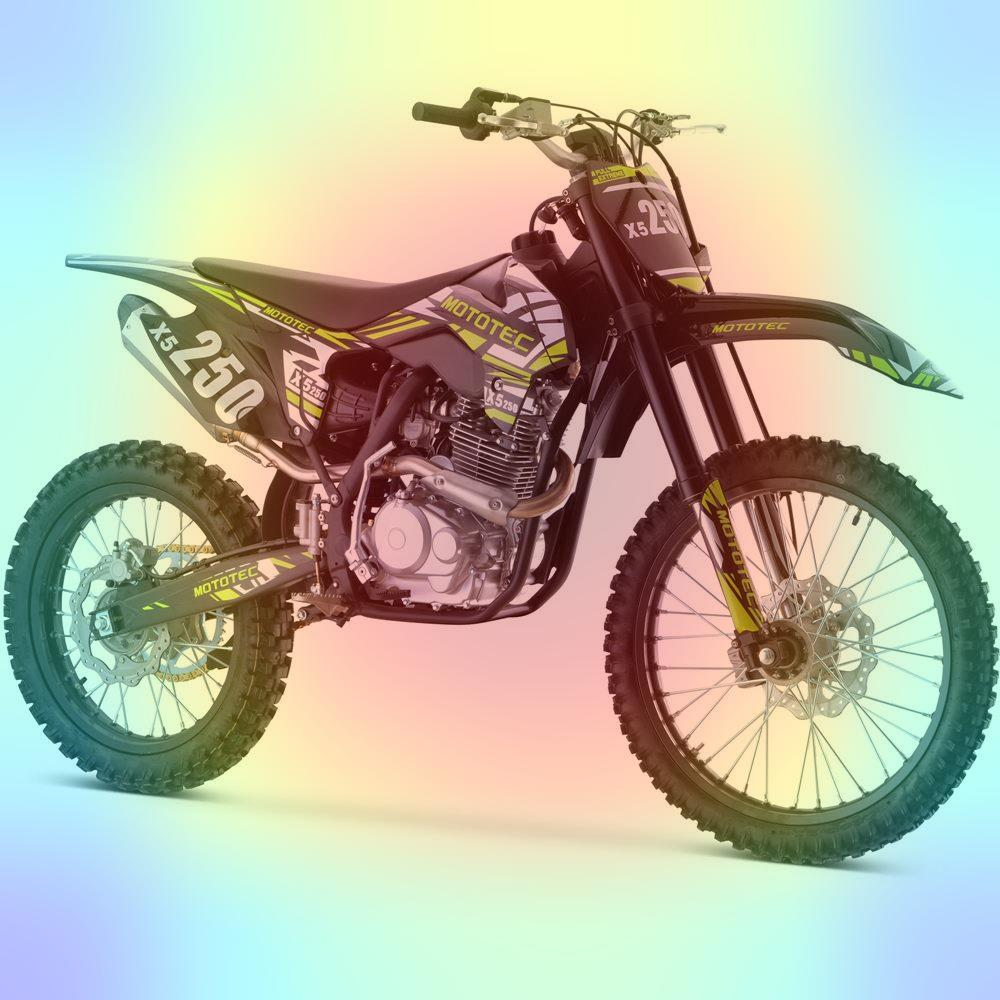

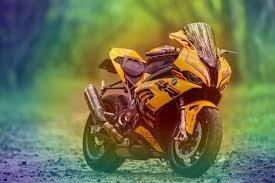

In [ ]:
img_path_lst = [
    "./raw_data_test/adventure/timthumb.png",
    './raw_data_test/cruiser/tacita_urban_cruiser_blog.jpg',
    "./raw_data_test/dirt/MT-DB-X5-250cc_Black.jpg",
    './raw_data_test/sport/images535.jpg',
    
]

last_conv_layer_name = 'conv5_block3_out'
for img_path in img_path_lst:
    img_array = get_img_array(img_path, (224,224))
    heatmap = make_gradcam_heatmap(img_array, resnet_fz, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap)


In [ ]:
label_lst

['adventure', 'cruiser', 'dirt', 'sport']

In [ ]:
_pred = transfer_model.predict(img_array)
_acutal = img_path.split('/')[-2]
print('Predict :',label_lst[np.argmax(_pred)], '\t Actual :', _acutal)

Predict : sport 	 Actual : cruiser


In [ ]:
_pred

array([[0.07532601, 0.13362598, 0.08462616, 0.7064219 ]], dtype=float32)

#### Autotune (caching??)

In [ ]:
tf.data.AUTOTUNE

-1

#### test rouding 

In [ ]:
print(f'{i:.6f}')

0.000677


In [ ]:
for i in transfer_model.predict(raw_test)[1]:
    print(f'{i:.6f}')

0.002387
0.981088
0.016520
0.000004
